In [1]:
import os
import ast
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates
import statsmodels.api as sm # 用于统计检验
%matplotlib inline
plt.rcParams["font.sans-serif"]=["WenQuanYi Micro Hei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

## 参数选择

In [27]:
# # Parameters
# CLUSTER_INDEX = 2
# EMO_INDEX = 0

In [3]:
ORI_DATA_PATH = '/data/public/fintechlab/zdh/Individual-Stock-Analysis/B_Temporal_Clustering/data'
ROOT_PATH = '/data/public/fintechlab/zdh/Individual-Stock-Analysis/B_Result_Analysis'
CLUSTER_PATH = f'{ROOT_PATH}/data/Comparison_of_Clustering_methods'

CLUSTER = ['Density', 'Features', 'Representation', 'Shape'][CLUSTER_INDEX]
Emotion_Data_PATH = f'{ORI_DATA_PATH}/Emotion_Data/Deep-learning/BERT'   # 情绪数据路径
Financial_Data_PATH = f'{ORI_DATA_PATH}/Financial_Data' # 金融数据路径

In [4]:
EMO_MARKET = ['Shanghai_Composite_Index', 'CSI_300_Index', 'Chinext_Index'][EMO_INDEX]
EMO_INDEX_MAP = {
    'Shanghai_Composite_Index': '上证综合情绪值',
    'CSI_300_Index': '沪深300情绪值',
    'Chinext_Index': '创业板情绪值'
}
EMO_NAME = EMO_INDEX_MAP[EMO_MARKET]

## 数据预处理

In [5]:
## 读取聚类结果
cluster_data = pd.read_csv(f'{CLUSTER_PATH}/{EMO_MARKET}/{CLUSTER}.csv', dtype={"Stkcd": str})
cluster_data.columns = ['股票编号', '聚类标签', '公司名称']
cluster_data.head()

股票编号  聚类标签   公司名称
0  000002     2    万科A
1  000061     2    农产品
2  000063     1   中兴通讯
3  000069     2   华侨城A
4  000100     1  TCL科技

In [6]:
## 读取股吧个股的数据
all_data = []
file_list = [f for f in os.listdir(Emotion_Data_PATH) if f.endswith('.csv')]

for file in file_list:
    file_path = os.path.join(Emotion_Data_PATH, file)
    df = pd.read_csv(file_path)
    stock_code = os.path.splitext(file)[0] # 获取股票编号（文件名去掉扩展名）
    
    # 提取每一行的日期和情绪值
    for _, row in df.iterrows():
        new_row = {
            '股票编号': stock_code,
            '日期': row['日期'],
            '上证综合情绪值': row['上证综合情绪值'],
            '沪深300情绪值': row['沪深300情绪值'],
            '创业板情绪值': row['创业板情绪值']
        }
        all_data.append(new_row)
guba_data = pd.DataFrame(all_data)
guba_data

股票编号          日期  上证综合情绪值  沪深300情绪值  创业板情绪值
0       601933  2024-12-27    0.007    -0.044  -0.015
1       601933  2024-11-18   -0.155    -0.236  -0.354
2       601933  2024-11-17    0.001     0.022   0.004
3       601933  2024-11-17   -0.346    -0.337  -0.407
4       601933  2024-11-17   -0.247    -0.309  -0.358
...        ...         ...      ...       ...     ...
495326  601919  2021-04-09    0.253     0.327   0.457
495327  601919  2021-04-09   -0.177    -0.190  -0.196
495328  601919  2021-04-08    0.218     0.194   0.167
495329  601919  2021-04-08    0.148     0.142   0.346
495330  601919  2021-01-01   -0.129    -0.132  -0.159

[495331 rows x 5 columns]

In [7]:
## 读取股票回报率的数据
return_data = pd.read_csv(f'{Financial_Data_PATH}/日个股回报率.csv', dtype={'股票编号': str})
return_data

股票编号          日期       交易量     收益率变化
0       000002  2021-06-01  60990961 -0.003745
1       000002  2021-06-02  85354506  0.006015
2       000002  2021-06-03  50594187 -0.003363
3       000002  2021-06-04  71422364 -0.012748
4       000002  2021-06-07  64745280 -0.014812
...        ...         ...       ...       ...
154877  688981  2024-11-20  58507495 -0.017071
154878  688981  2024-11-21  56197106  0.002358
154879  688981  2024-11-22  79240108 -0.050588
154880  688981  2024-11-25  76905909 -0.029402
154881  688981  2024-11-26  35363542 -0.012303

[154882 rows x 4 columns]

In [8]:
## 进行左连接，以 guba_data 为主表
merged_data = pd.merge(guba_data, return_data[['股票编号', '日期', '交易量', '收益率变化']], 
                       on=['股票编号', '日期'], 
                       how='left')
merged_data = pd.merge(merged_data, cluster_data, on='股票编号', how='left')
merged_data = merged_data.dropna()

merged_data['日期'] = pd.to_datetime(merged_data['日期'])
merged_data = merged_data[(merged_data['日期'] > '2021-05-06') & (merged_data['日期'] < '2024-11-18')]
merged_data

股票编号         日期  上证综合情绪值  沪深300情绪值  创业板情绪值          交易量     收益率变化  \
11      601933 2024-11-15   -0.178    -0.191  -0.171  423271473.0 -0.064655   
12      601933 2024-11-15    0.072     0.066   0.130  423271473.0 -0.064655   
13      601933 2024-11-14   -0.019     0.027   0.068  372259052.0 -0.053061   
14      601933 2024-11-14   -0.006     0.012   0.003  372259052.0 -0.053061   
15      601933 2024-11-14   -0.051    -0.059  -0.004  372259052.0 -0.053061   
...        ...        ...      ...       ...     ...          ...       ...   
495148  601919 2021-06-01    0.265     0.327   0.476  268816321.0  0.045859   
495149  601919 2021-06-01   -0.006     0.002   0.020  268816321.0  0.045859   
495150  601919 2021-06-01   -0.034    -0.003   0.016  268816321.0  0.045859   
495151  601919 2021-06-01    0.041     0.018   0.071  268816321.0  0.045859   
495152  601919 2021-06-01   -0.071    -0.159  -0.063  268816321.0  0.045859   

        聚类标签  公司名称  
11       1.0  永辉超市  
12       1.0  永辉超市  
13       1.0  永辉超市  
14       1.0  永辉超市  
15       1.0  永辉超市  
...      ...   ...  
495148   1.0  中远海控  
495149   1.0  中远海控  
495150   1.0  中远海控  
495151   1.0  中远海控  
495152   1.0  中远海控  

[391134 rows x 9 columns]

In [9]:
# 对情绪值列进行 Min-Max 标准化
def min_max_normalization(df, cols):
    for col in cols:
        min_val = df[col].min()
        max_val = df[col].max()
        df[col] = 2 * (df[col] - min_val) / (max_val - min_val) - 1
    return df

# 对每个股票编号的数据进行标准化和按日期汇总
def process_data(df):
    df_processed = pd.DataFrame()  # 用于存储结果
    for stock_code, stock_data in df.groupby('股票编号'):
        # 对每个股票编号内的数据进行标准化
        stock_data = min_max_normalization(stock_data, ['上证综合情绪值', '沪深300情绪值', '创业板情绪值'])
        
        # 按日期汇总数据，同时保留股票编号
        stock_summary = stock_data.groupby('日期').agg({
            '股票编号': 'first',  # 保留股票编号（在同一日期内它是相同的，使用 'first'）
            '上证综合情绪值': 'mean',  # 上证综合情绪值按日期取均值
            '沪深300情绪值': 'mean',  # 沪深300情绪值按日期取均值
            '创业板情绪值': 'mean',  # 创业板情绪值按日期取均值
            '交易量': 'mean',  # 交易量按日期求和
            '收益率变化': 'mean',  # 收益率变化按日期取均值
            '聚类标签': 'first', # 保留聚类标签（在同一日期内它是相同的，使用 'first'）
            '公司名称': 'first', # 保留公司名称（在同一日期内它是相同的，使用 'first'）
        }).reset_index(drop=False)
        
        # 合并每个股票的汇总数据
        df_processed = pd.concat([df_processed, stock_summary], ignore_index=True)
        df_processed = df_processed.sort_values(by=['股票编号', '日期'], ascending=[True, True])
    return df_processed

final_data = process_data(merged_data)
final_data

日期    股票编号   上证综合情绪值  沪深300情绪值    创业板情绪值          交易量     收益率变化  \
0     2021-06-01  000002  0.316338  0.267833  0.280789   60990961.0 -0.003745   
1     2021-06-08  000002  0.347227  0.287914  0.300312   44676494.0  0.004626   
2     2021-06-10  000002  0.325725  0.281754  0.289027   53800776.0 -0.010035   
3     2021-06-11  000002  0.285945  0.224180  0.235237   75853738.0 -0.014035   
4     2021-06-15  000002  0.314849  0.268572  0.283593   89915501.0 -0.020957   
...          ...     ...       ...       ...       ...          ...       ...   
85279 2024-11-11  688981  0.347604  0.325915  0.231295  138069018.0  0.046660   
85280 2024-11-12  688981  0.360433  0.328320  0.235728  108866759.0 -0.036864   
85281 2024-11-13  688981  0.269057  0.242652  0.142033   80759477.0 -0.019484   
85282 2024-11-14  688981  0.286646  0.247683  0.160005   76194102.0 -0.022897   
85283 2024-11-15  688981  0.244977  0.218178  0.099522   71066743.0 -0.020233   

       聚类标签  公司名称  
0       2.0   万科A  
1       2.0   万科A  
2       2.0   万科A  
3       2.0   万科A  
4       2.0   万科A  
...     ...   ...  
85279   1.0  中芯国际  
85280   1.0  中芯国际  
85281   1.0  中芯国际  
85282   1.0  中芯国际  
85283   1.0  中芯国际  

[85284 rows x 9 columns]

In [10]:
# 统计检验 : 按照聚类标签分组，并计算均值和方差
df = final_data.copy()
statistical_result = df.groupby('聚类标签').agg(
    情绪值均值=(EMO_NAME, 'mean'),
    情绪值方差=(EMO_NAME, 'var'),
    收益率变化均值=('收益率变化', 'mean'),
    收益率变化方差=('收益率变化', 'var')
).reset_index()

# 输出结果
statistical_result

聚类标签     情绪值均值     情绪值方差   收益率变化均值   收益率变化方差
0   0.0  0.143512  0.036926  0.000733  0.000701
1   1.0  0.194787  0.044242  0.000652  0.000749
2   2.0  0.176191  0.039011  0.000334  0.000737

## 情绪值与股价二维展示图

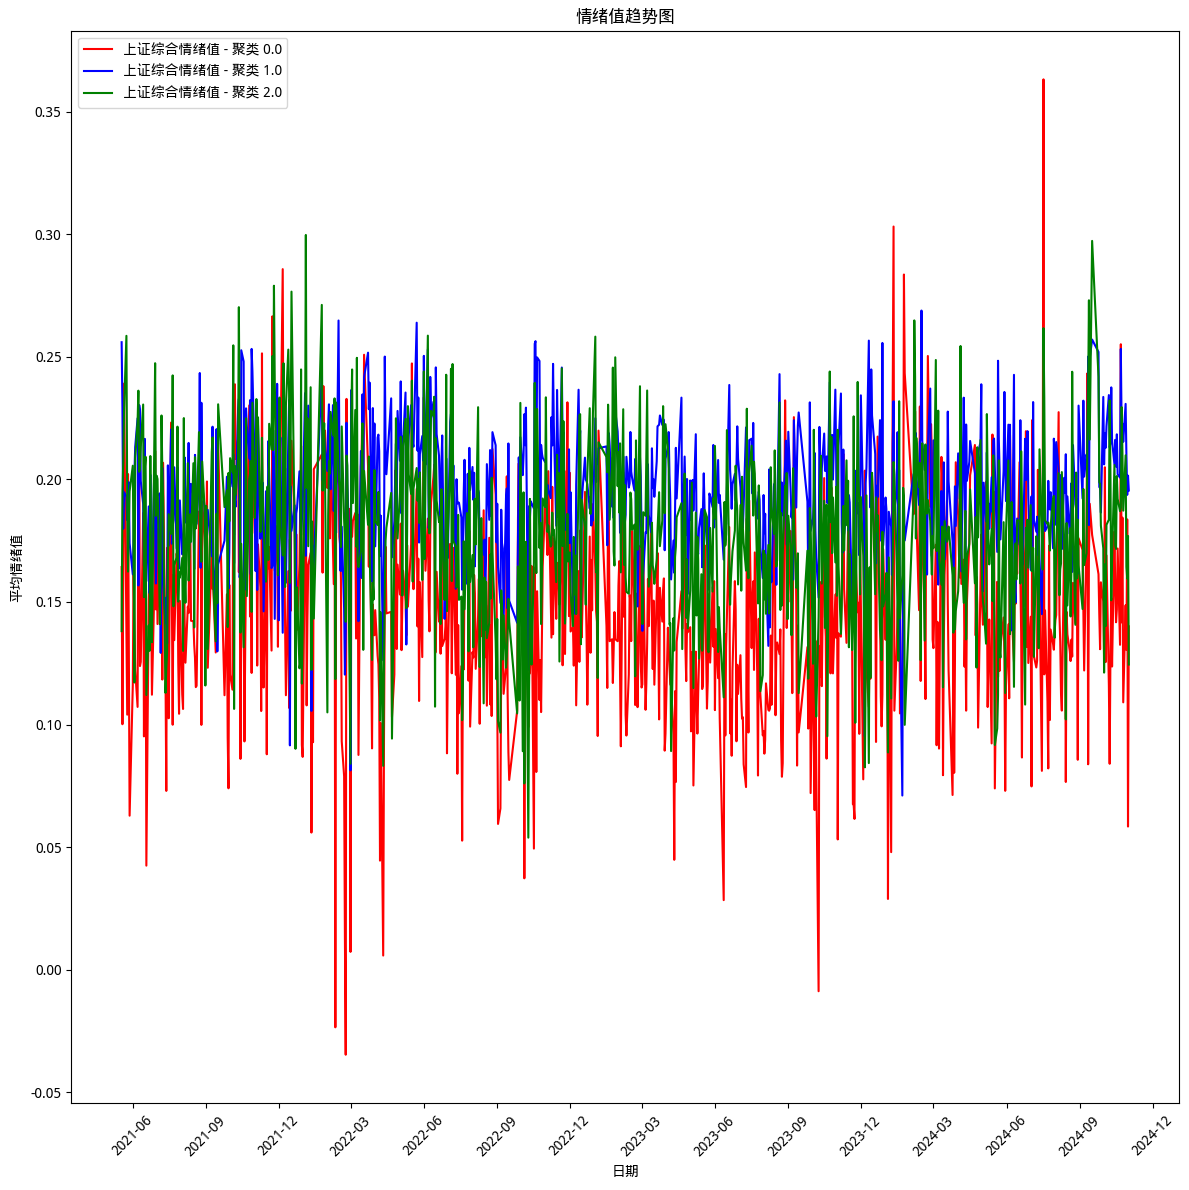

In [11]:
## 绘制不同簇情绪值随时间变化图

# 按 '聚类标签' 和 '日期' 分组，计算平均情绪值
df_grouped = final_data.groupby(['聚类标签', '日期'])[['上证综合情绪值', '沪深300情绪值', '创业板情绪值']].mean().reset_index()

# 为每个聚类标签绘制折线
i = 0
plt.figure(figsize=(12, 12))
for cluster in df_grouped['聚类标签'].unique():
    if i == 0:
        x = 'red'
    elif i == 1:
        x = 'blue'
    elif i == 2:
        x = 'green'
    df_cluster = df_grouped[df_grouped['聚类标签'] == cluster]
    plt.plot(df_cluster['日期'], df_cluster[EMO_NAME], label=f'{EMO_NAME} - 聚类 {cluster}', color=x)
    i += 1
    
plt.xlabel('日期')
plt.ylabel('平均情绪值')
plt.title('情绪值趋势图')


plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=15, interval=3))  # 每三个月显示
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 格式化为年-月

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# plt.savefig(f'个股分析/{market_address}/图片/情绪值趋势图', dpi=300)
plt.show()


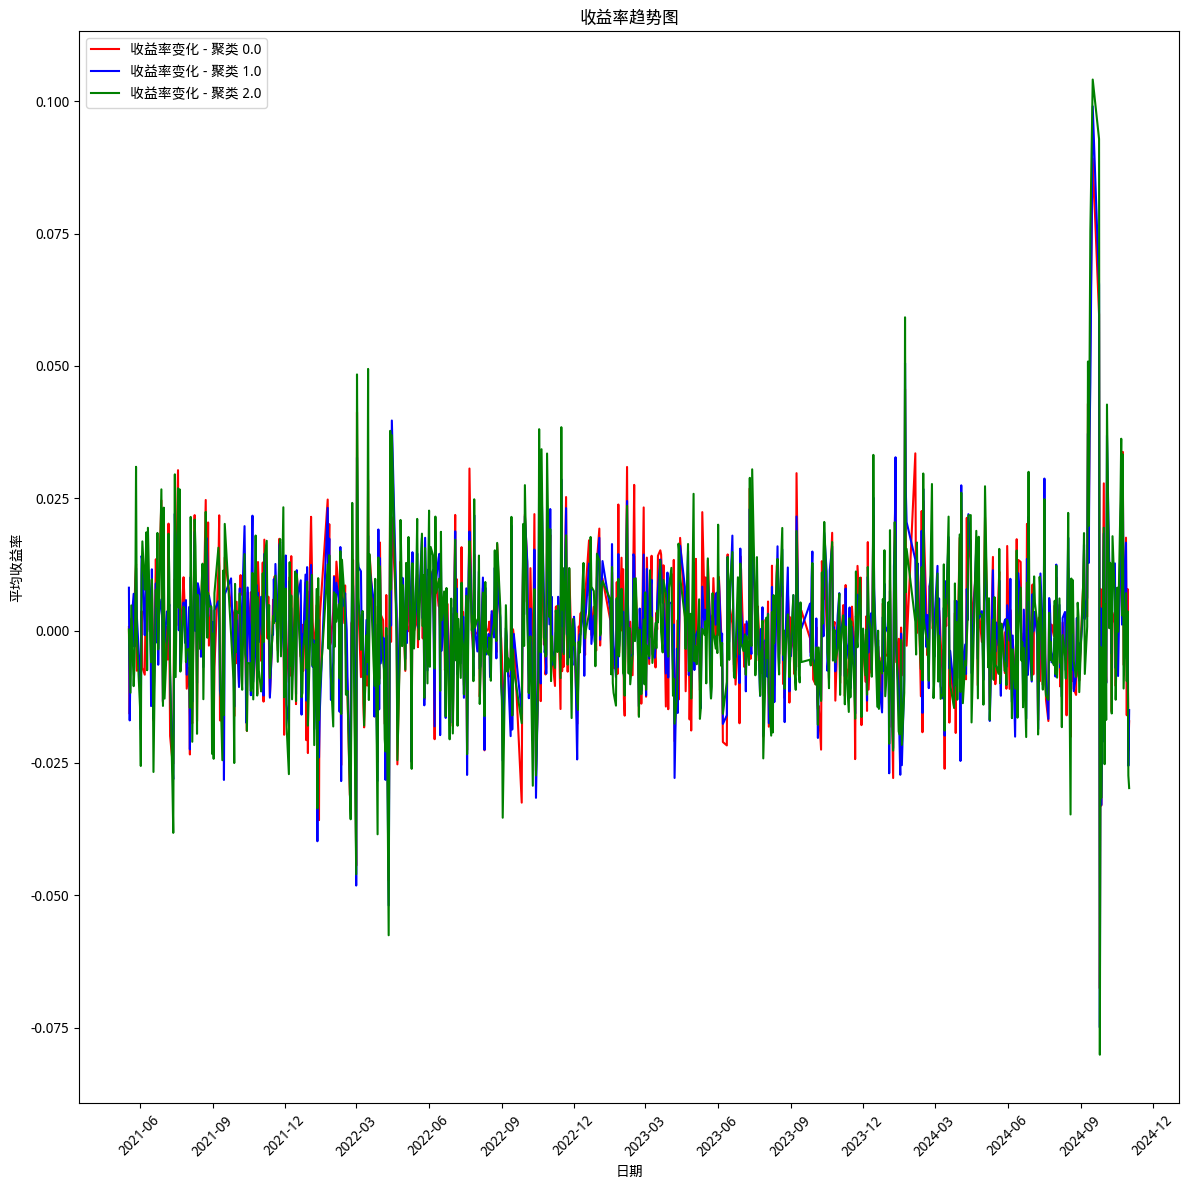

In [12]:
## 绘制不同簇收益率随时间变化图

# 按 '聚类标签' 和 '日期' 分组，计算平均收益率
return_grouped = final_data.groupby(['聚类标签', '日期'])['收益率变化'].mean().reset_index()

# 为每个聚类标签绘制折线
i = 0
plt.figure(figsize=(12, 12))
for cluster in df_grouped['聚类标签'].unique():
    if i == 0:
        x = 'red'
    elif i == 1:
        x = 'blue'
    elif i == 2:
        x = 'green'
    df_cluster = return_grouped[return_grouped['聚类标签'] == cluster]
    plt.plot(df_cluster['日期'], df_cluster['收益率变化'], label=f'收益率变化 - 聚类 {cluster}', color=x)
    i += 1

plt.xlabel('日期')
plt.ylabel('平均收益率')
plt.title('收益率趋势图')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=15, interval=3))  # 每三个月显示
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 格式化为年-月

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# 显示图表
# plt.savefig(f'个股分析/{market_address}/图片/收益率趋势图', dpi=300)
plt.show()

## 三维展示图，分别展示簇是0，1，2的代表图

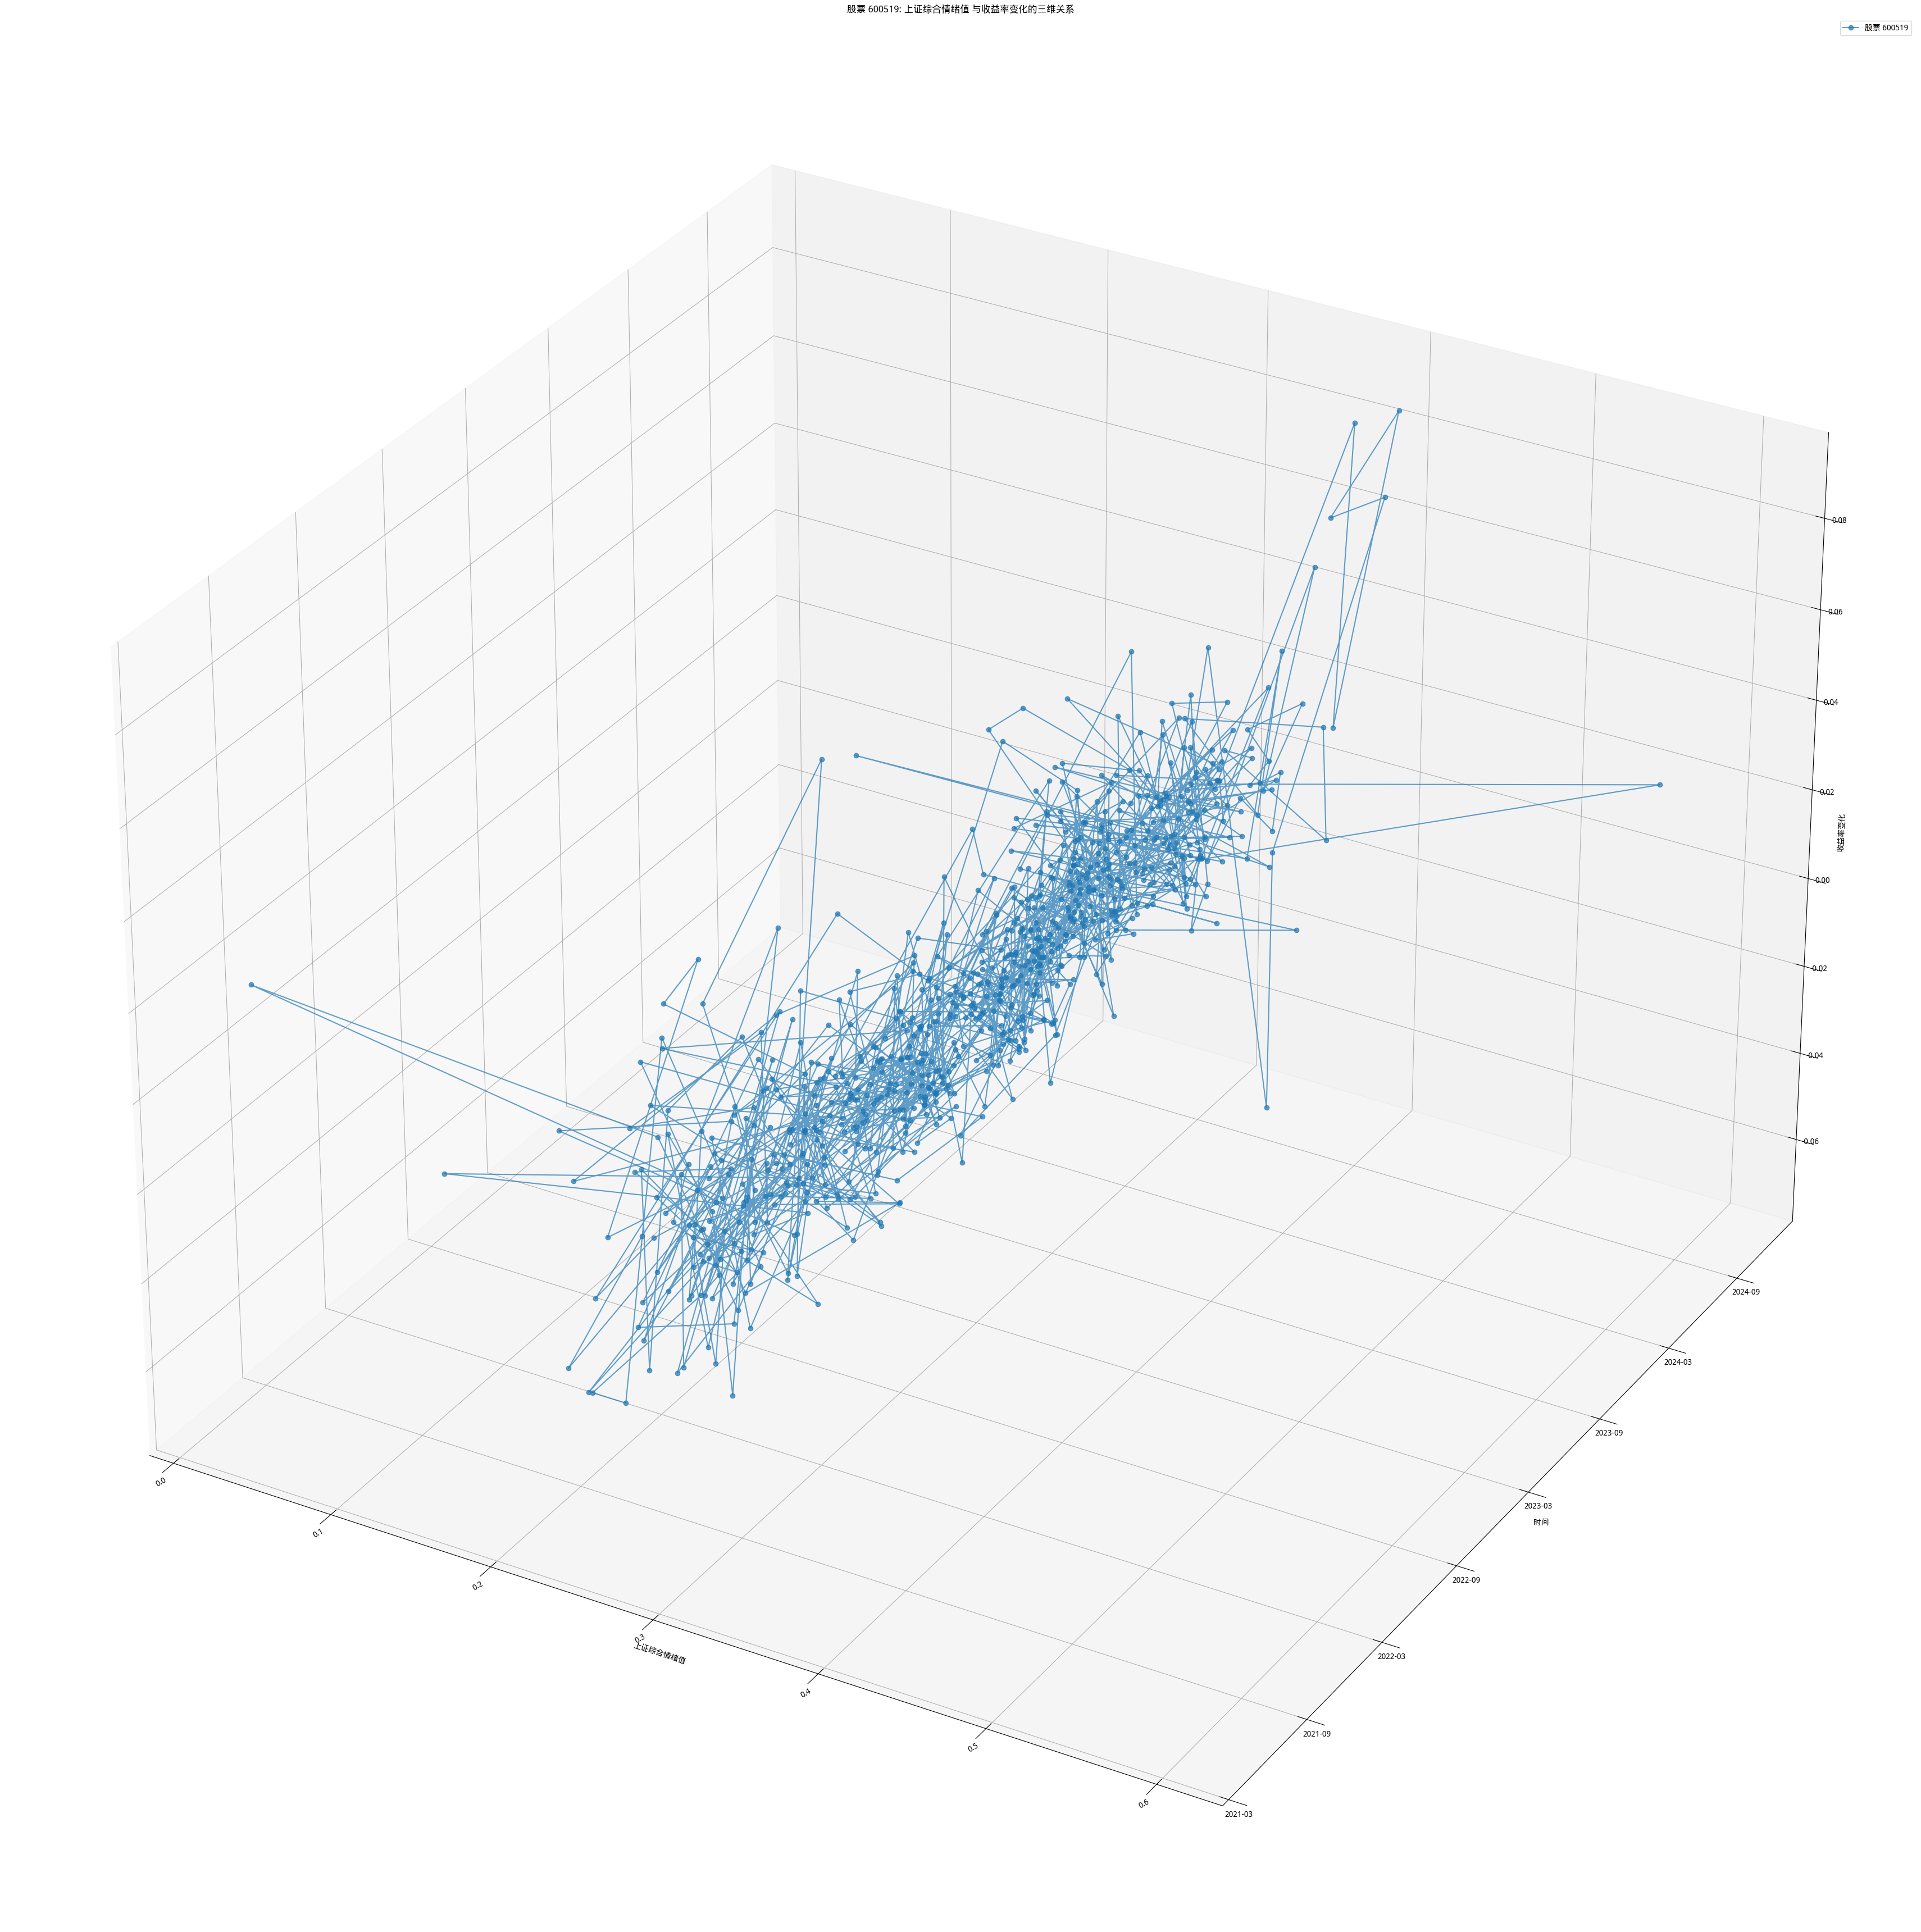

In [13]:
### 聚类0示例 ###

# 复制数据集，确保不会修改原始数据
merged_data_cleaned = final_data.copy()
merged_data_cleaned['日期'] = pd.to_datetime(merged_data_cleaned['日期'])

# 选择聚类标签为 0 的数据，找到数据最多的股票编号
cluster_0_data = merged_data_cleaned[merged_data_cleaned['聚类标签'] == 0]
top_stock_code = cluster_0_data['股票编号'].value_counts().idxmax()
top_stock_data = cluster_0_data[cluster_0_data['股票编号'] == top_stock_code]

# 创建 3D 图
fig = plt.figure(figsize=(50, 50))
ax = fig.add_subplot(111, projection='3d')

# 提取绘图数据
x = top_stock_data[EMO_NAME]  # 情绪值作为 x 轴
y = mdates.date2num(top_stock_data['日期'])  # 时间转换为数值类型
z = top_stock_data['收益率变化']  # 收益率变化作为 z 轴

# 绘制三维折线图
ax.plot(x, y, z, label=f"股票 {top_stock_code}", marker='o', linestyle='-', alpha=0.7)

# 设置轴标签
ax.set_xlabel(EMO_NAME)
ax.set_ylabel('时间')
ax.set_zlabel('收益率变化')
ax.set_title(f'股票 {top_stock_code}: {EMO_NAME} 与收益率变化的三维关系')

# 设置 y 轴时间刻度（每半年一个刻度）
ax.yaxis.set_major_locator(mdates.MonthLocator(bymonthday=15, interval=6))  # 每半年一个刻度
ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 按年月显示

# 旋转日期标签防止重叠
fig.autofmt_xdate()

# 调整布局并保存图像
plt.legend()
# plt.savefig(f'个股分析/{market_address}/图片/聚类0_{top_stock_code}.png', dpi=300, bbox_inches='tight')
plt.show()


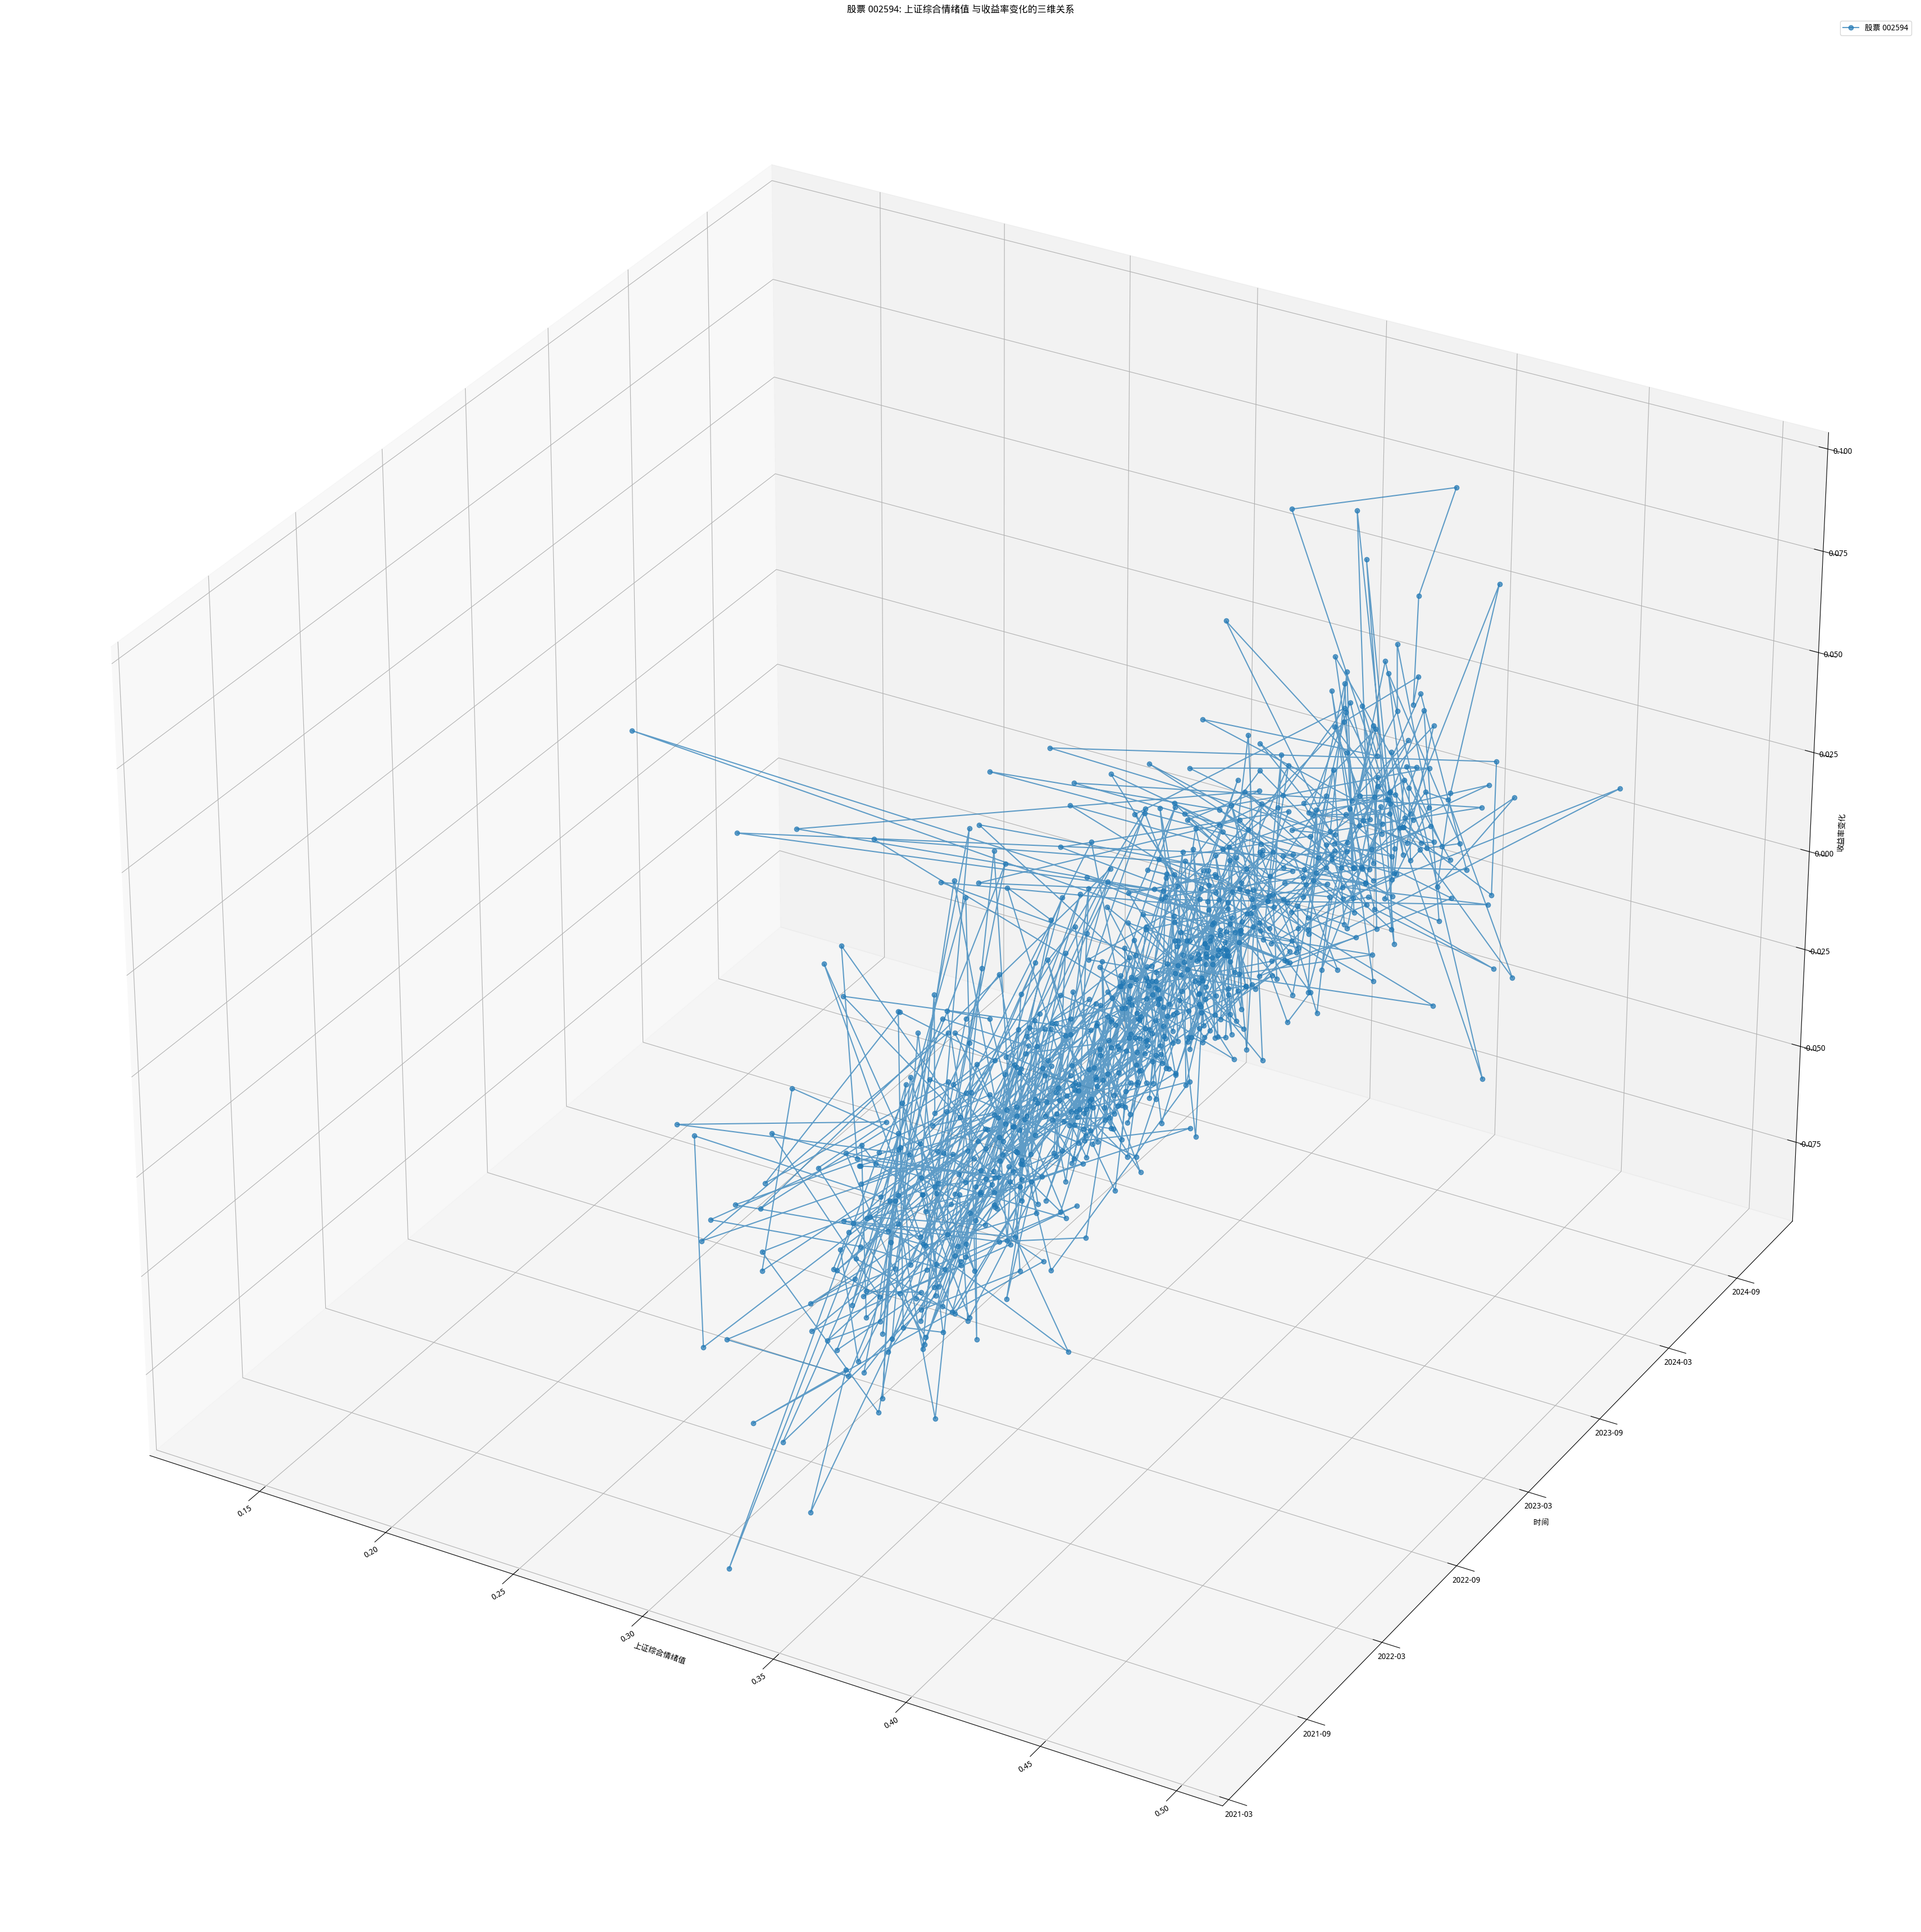

In [14]:
### 聚类1示例 ###
# 复制数据集，确保不会修改原始数据
merged_data_cleaned = final_data.copy()
merged_data_cleaned['日期'] = pd.to_datetime(merged_data_cleaned['日期'])

# 选择聚类标签为 0 的数据，找到数据最多的股票编号
cluster_0_data = merged_data_cleaned[merged_data_cleaned['聚类标签'] == 1]
top_stock_code = cluster_0_data['股票编号'].value_counts().idxmax()
top_stock_data = cluster_0_data[cluster_0_data['股票编号'] == top_stock_code]


# 创建 3D 图
fig = plt.figure(figsize=(50, 50))
ax = fig.add_subplot(111, projection='3d')

# 提取绘图数据
x = top_stock_data[EMO_NAME]  # 情绪值作为 x 轴
y = mdates.date2num(top_stock_data['日期'])  # 时间转换为数值类型
z = top_stock_data['收益率变化']  # 收益率变化作为 z 轴

# 绘制三维折线图
ax.plot(x, y, z, label=f"股票 {top_stock_code}", marker='o', linestyle='-', alpha=0.7)

# 设置轴标签
ax.set_xlabel(EMO_NAME)
ax.set_ylabel('时间')
ax.set_zlabel('收益率变化')
ax.set_title(f'股票 {top_stock_code}: {EMO_NAME} 与收益率变化的三维关系')

# 设置 y 轴时间刻度（每半年一个刻度）
ax.yaxis.set_major_locator(mdates.MonthLocator(bymonthday=15, interval=6))  # 每半年一个刻度
ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 按年月显示

# 旋转日期标签防止重叠
fig.autofmt_xdate()

# 调整布局并保存图像
plt.legend()
# plt.savefig(f'个股分析/{market_address}/图片/聚类1_{top_stock_code}.png', dpi=300, bbox_inches='tight')
plt.show()


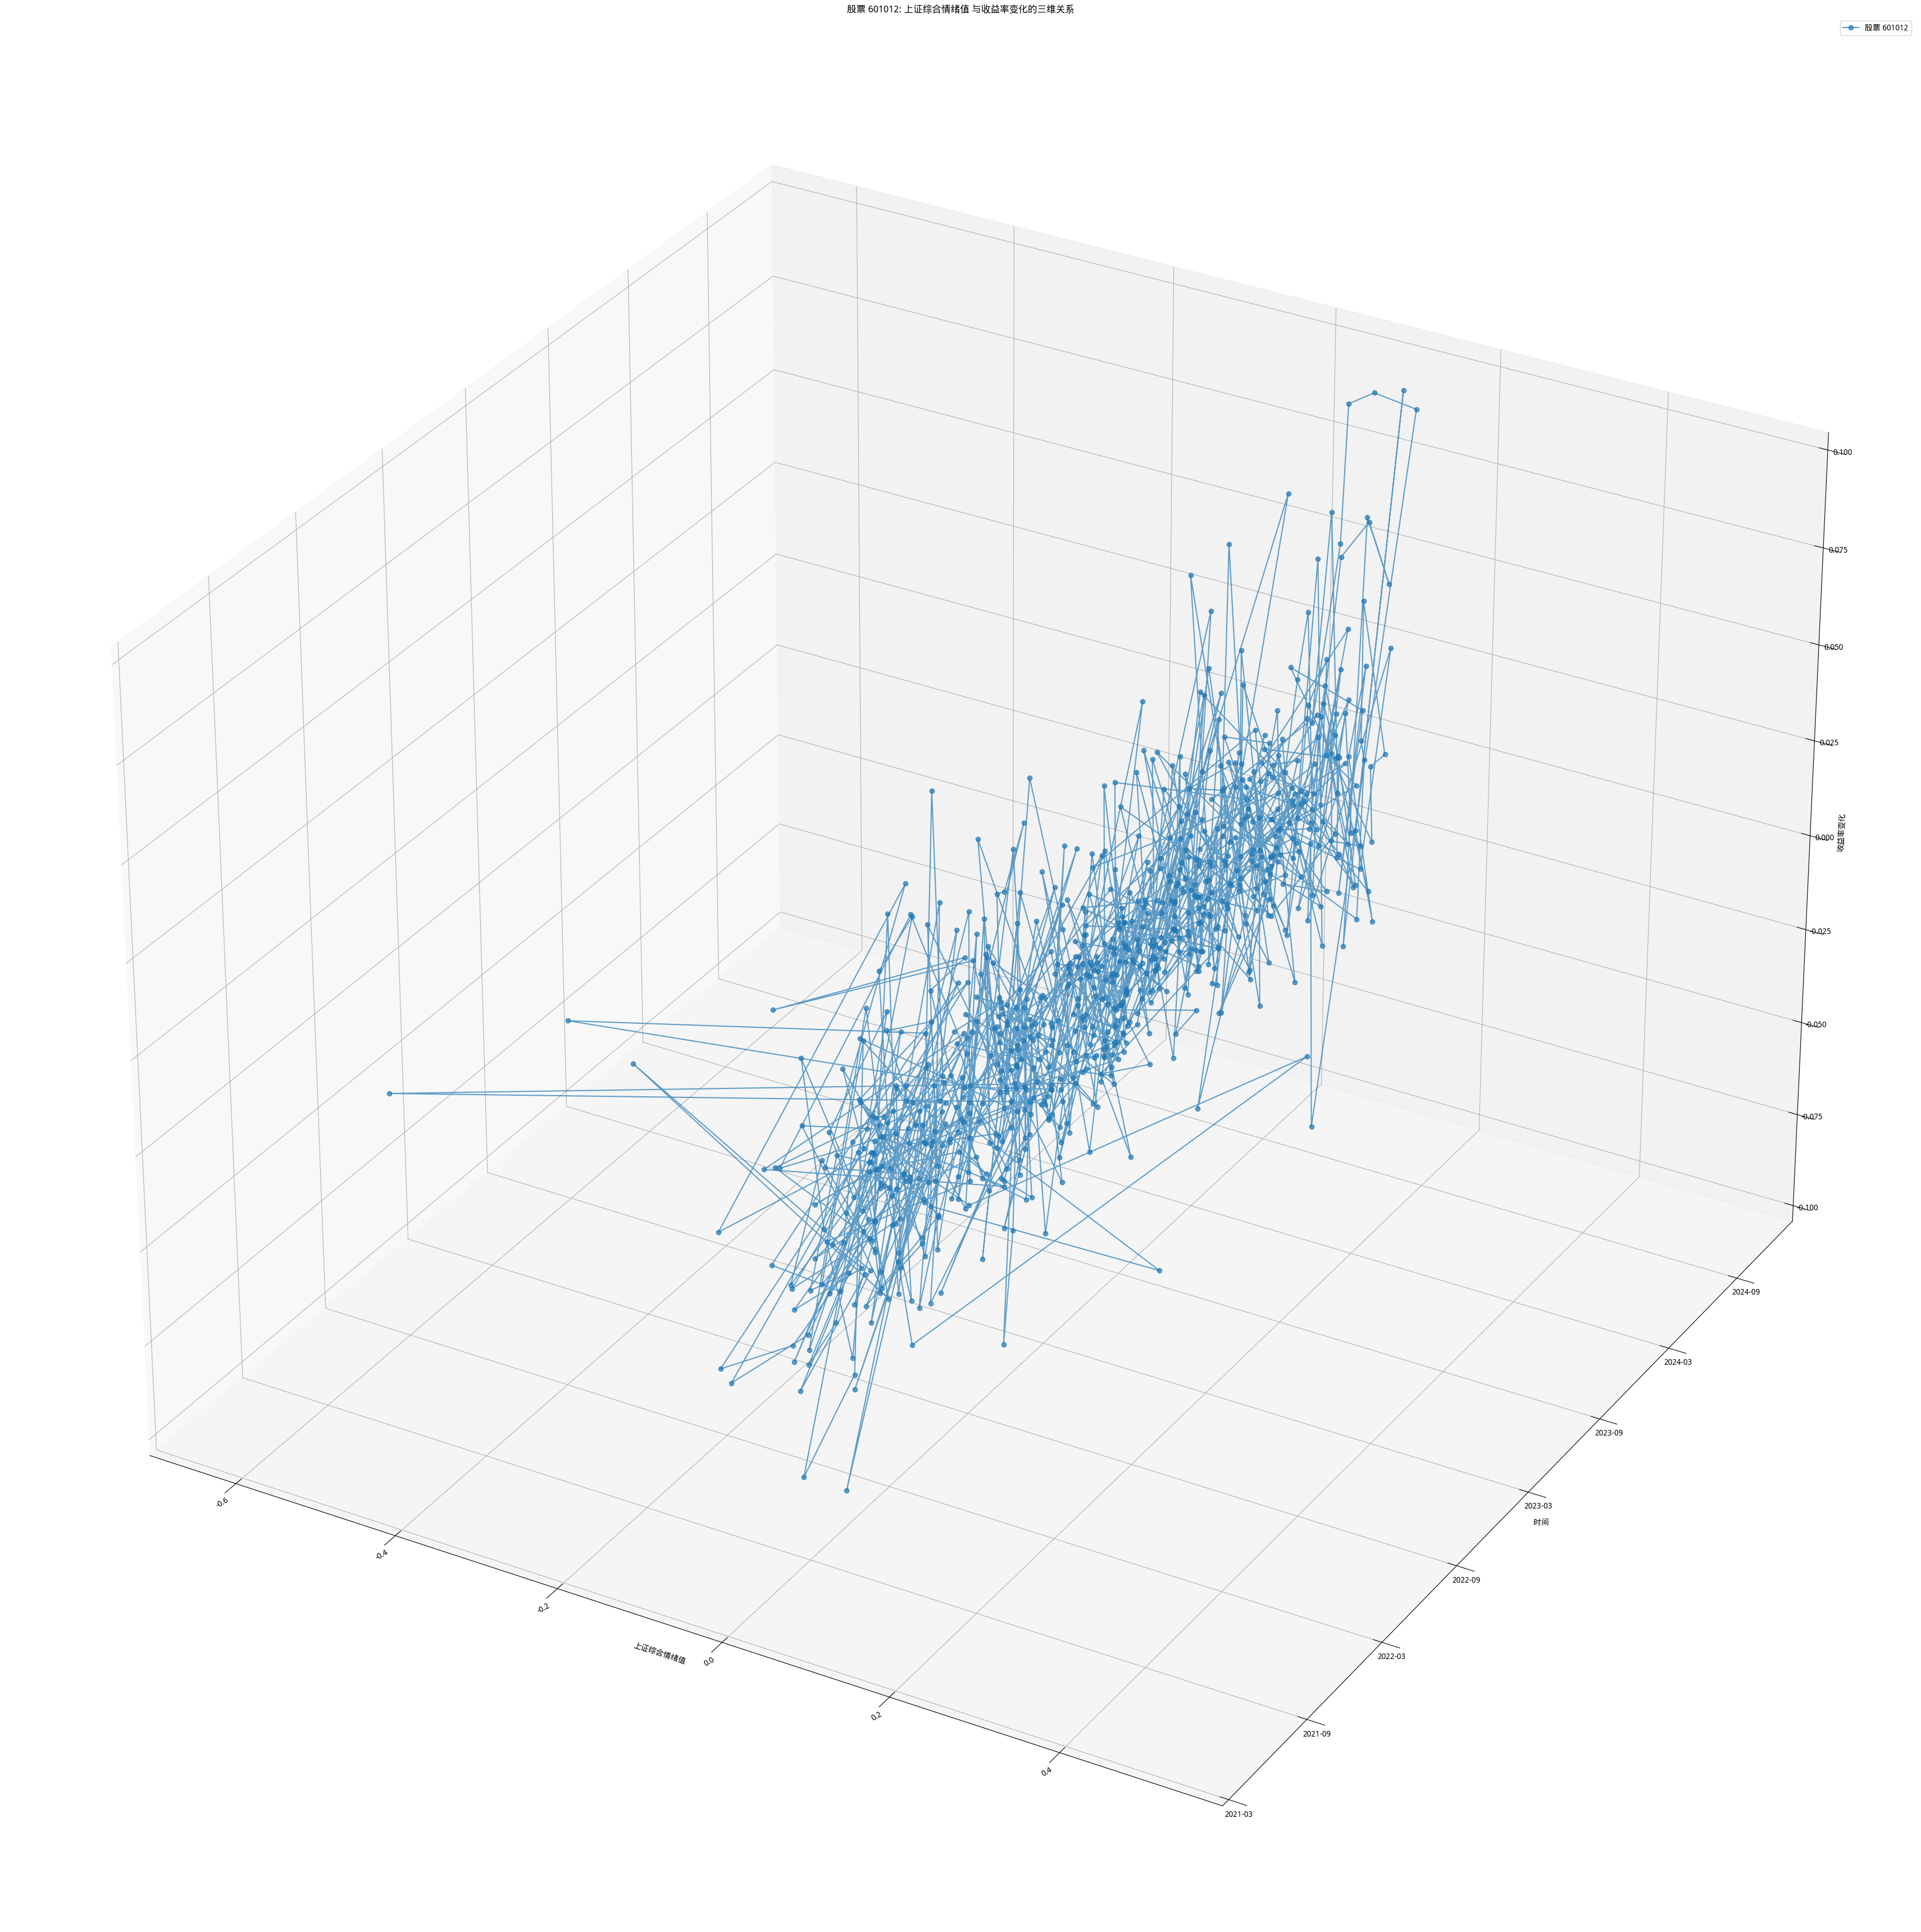

In [15]:
### 聚类2示例 ###
# 复制数据集，确保不会修改原始数据
merged_data_cleaned = final_data.copy()
merged_data_cleaned['日期'] = pd.to_datetime(merged_data_cleaned['日期'])

# 选择聚类标签为 0 的数据，找到数据最多的股票编号
cluster_0_data = merged_data_cleaned[merged_data_cleaned['聚类标签'] == 2]
top_stock_code = cluster_0_data['股票编号'].value_counts().idxmax()
top_stock_data = cluster_0_data[cluster_0_data['股票编号'] == top_stock_code]


# 创建 3D 图
fig = plt.figure(figsize=(50, 50))
ax = fig.add_subplot(111, projection='3d')

# 提取绘图数据
x = top_stock_data[EMO_NAME]  # 情绪值作为 x 轴
y = mdates.date2num(top_stock_data['日期'])  # 时间转换为数值类型
z = top_stock_data['收益率变化']  # 收益率变化作为 z 轴

# 绘制三维折线图
ax.plot(x, y, z, label=f"股票 {top_stock_code}", marker='o', linestyle='-', alpha=0.7)

# 设置轴标签
ax.set_xlabel(EMO_NAME)
ax.set_ylabel('时间')
ax.set_zlabel('收益率变化')
ax.set_title(f'股票 {top_stock_code}: {EMO_NAME} 与收益率变化的三维关系')

# 设置 y 轴时间刻度（每半年一个刻度）
ax.yaxis.set_major_locator(mdates.MonthLocator(bymonthday=15, interval=6))  # 每半年一个刻度
ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 按年月显示

# 旋转日期标签防止重叠
fig.autofmt_xdate()

# 调整布局并保存图像
plt.legend()
# plt.savefig(f'个股分析/{market_address}/图片/聚类2_{top_stock_code}.png', dpi=300, bbox_inches='tight')
plt.show()


## 进行聚类间实证分析

#### 读取个股金融数据

In [16]:
# 读取原始数据
microfinancial_data = pd.read_csv(f'{Financial_Data_PATH}/个股微观金融数据.csv', encoding='utf-8')

# 选择重要的列，日期和股票代码一定要包含
columns_to_select = [
    '日期_Date',  # 日期
    '股票代码_Stkcd',  # 股票代码
    '日振幅(%)_Dampltd',  # 日振幅
    '日收益率_Dret',  # 日收益率
    '市盈率_PE',  # 市盈率
    '成交量_Trdvol',  # 成交量
    '流通股日换手率(%)_DTrdTurnR',
    '总市值加权平均日资本收益_Daretmc',
]

# 提取相关列
microfinancial_data = microfinancial_data[columns_to_select]
microfinancial_data['股票代码_Stkcd'] = microfinancial_data['股票代码_Stkcd'].apply(lambda x: str(x).zfill(6))

# microfinancial_data = microfinancial_data[microfinancial_data['日期_Date'] == '2022-03-01'] #用于检验某一天数据
microfinancial_data

日期_Date 股票代码_Stkcd  日振幅(%)_Dampltd  日收益率_Dret  市盈率_PE   成交量_Trdvol  \
0       2023-02-01     000100          1.6667     0.0071  276.47  147751077.0   
1       2023-02-02     000100          2.1277    -0.0095  273.86  188929965.0   
2       2023-02-03     000100          2.1480    -0.0048  272.55  200087013.0   
3       2023-02-06     000100          1.6787    -0.0072  270.59  134158688.0   
4       2023-02-07     000100          1.4493     0.0024  271.24   87200030.0   
...            ...        ...             ...        ...     ...          ...   
162617  2024-11-14     601566          3.0340    -0.0255   16.94    3223500.0   
162618  2024-11-15     601566          2.8643     0.0025   16.98    2824500.0   
162619  2024-11-18     601566          3.8509    -0.0025   16.94    3729993.0   
162620  2024-11-19     601566          2.3661     0.0137   17.17    3367065.0   
162621  2024-11-20     601566          2.4570     0.0172   17.46    4148800.0   

        流通股日换手率(%)_DTrdTurnR  总市值加权平均日资本收益_Daretmc  
0                     1.0357                0.0145  
1                     1.3244               -0.0005  
2                     1.4026               -0.0042  
3                     0.9404               -0.0084  
4                     0.6113                0.0036  
...                      ...                   ...  
162617                0.5610               -0.0146  
162618                0.4915               -0.0112  
162619                0.6491                0.0009  
162620                0.5859                0.0031  
162621                0.7220                0.0054  

[162622 rows x 8 columns]

#### 加载之前的情绪聚类数据

In [17]:
final_data

日期    股票编号   上证综合情绪值  沪深300情绪值    创业板情绪值          交易量     收益率变化  \
0     2021-06-01  000002  0.316338  0.267833  0.280789   60990961.0 -0.003745   
1     2021-06-08  000002  0.347227  0.287914  0.300312   44676494.0  0.004626   
2     2021-06-10  000002  0.325725  0.281754  0.289027   53800776.0 -0.010035   
3     2021-06-11  000002  0.285945  0.224180  0.235237   75853738.0 -0.014035   
4     2021-06-15  000002  0.314849  0.268572  0.283593   89915501.0 -0.020957   
...          ...     ...       ...       ...       ...          ...       ...   
85279 2024-11-11  688981  0.347604  0.325915  0.231295  138069018.0  0.046660   
85280 2024-11-12  688981  0.360433  0.328320  0.235728  108866759.0 -0.036864   
85281 2024-11-13  688981  0.269057  0.242652  0.142033   80759477.0 -0.019484   
85282 2024-11-14  688981  0.286646  0.247683  0.160005   76194102.0 -0.022897   
85283 2024-11-15  688981  0.244977  0.218178  0.099522   71066743.0 -0.020233   

       聚类标签  公司名称  
0       2.0   万科A  
1       2.0   万科A  
2       2.0   万科A  
3       2.0   万科A  
4       2.0   万科A  
...     ...   ...  
85279   1.0  中芯国际  
85280   1.0  中芯国际  
85281   1.0  中芯国际  
85282   1.0  中芯国际  
85283   1.0  中芯国际  

[85284 rows x 9 columns]

#### 读取市场换手率与市盈率并进行插值

In [18]:
turnover_PE_rate = pd.read_csv(f'{Financial_Data_PATH}/市场整体换手率与市盈率.csv', encoding='utf-8')
turnover_PE_rate['统计日期'] = pd.to_datetime(turnover_PE_rate['统计日期'])

# 按照 '统计日期' 排序
turnover_PE_rate = turnover_PE_rate.sort_values(by='统计日期')

# 对 '平均市盈率' 和 '换手率(总股本)' 进行线性插值
turnover_PE_rate[['平均市盈率', '换手率(总股本)']] = turnover_PE_rate[['平均市盈率', '换手率(总股本)']].interpolate(method='linear', axis=0)

turnover_PE_rate = turnover_PE_rate.drop(columns=['统计口径编码'])
turnover_PE_rate.columns = ['统计日期', '市场平均市盈率', '市场换手率(总股本)']
turnover_PE_rate

统计日期    市场平均市盈率  市场换手率(总股本)
0     2021-01-04  16.918000    1.140600
12    2021-01-04  25.986305    1.237217
11    2021-01-04  35.054611    1.333834
10    2021-01-04  44.122916    1.430451
8     2021-01-04  53.191221    1.527068
...          ...        ...         ...
12364 2024-12-06  39.185061    2.176139
12363 2024-12-06  14.390000    1.292500
12374 2024-12-06  14.390000    1.292500
12368 2024-12-06  14.390000    1.292500
12375 2024-12-06  14.390000    1.292500

[12376 rows x 3 columns]

#### 数据拼接

In [19]:
# 将日期列转换为 datetime 格式
final_data['日期'] = pd.to_datetime(final_data['日期'])
microfinancial_data['日期_Date'] = pd.to_datetime(microfinancial_data['日期_Date'], errors='coerce')

# 使用 merge 进行内连接
result = pd.merge(
    final_data, 
    microfinancial_data, 
    left_on=['日期', '股票编号'],  # 左表的 key
    right_on=['日期_Date', '股票代码_Stkcd'], # 右表的 key
    how='inner'                   # 内连接
)

result = pd.merge(
    result, 
    turnover_PE_rate, 
    left_on=['日期'],  # 左表的 key
    right_on=['统计日期'], # 右表的 key
    how='inner'                   # 内连接
)

# 删除重复的列
result = result.drop(columns=['日期_Date', '股票代码_Stkcd', '交易量', '日收益率_Dret', '统计日期'])

# 修改列的位置，更加美观可视
columns_to_move = ['聚类标签', '公司名称']
result = pd.concat([result.drop(columns=columns_to_move), result[columns_to_move]], axis=1)

# 将成交量除以10000，并以万计数
result['成交量(百万)_Trdvol'] = result['成交量_Trdvol'] / 1_000_000
result = result.drop(columns=['成交量_Trdvol'])

cols_to_check = ['收益率变化', '日振幅(%)_Dampltd', '市盈率_PE', 
                 '成交量(百万)_Trdvol', '流通股日换手率(%)_DTrdTurnR']

# 删除含有空值的行
result = result.dropna(subset=cols_to_check)
result

日期    股票编号   上证综合情绪值  沪深300情绪值    创业板情绪值     收益率变化  \
0       2021-06-01  000002  0.316338  0.267833  0.280789 -0.003745   
1       2021-06-01  000002  0.316338  0.267833  0.280789 -0.003745   
2       2021-06-01  000002  0.316338  0.267833  0.280789 -0.003745   
3       2021-06-01  000002  0.316338  0.267833  0.280789 -0.003745   
4       2021-06-01  000002  0.316338  0.267833  0.280789 -0.003745   
...            ...     ...       ...       ...       ...       ...   
1146205 2024-11-15  603986  0.131915  0.078548  0.049395 -0.028519   
1146206 2024-11-15  603986  0.131915  0.078548  0.049395 -0.028519   
1146207 2024-11-15  603986  0.131915  0.078548  0.049395 -0.028519   
1146208 2024-11-15  603986  0.131915  0.078548  0.049395 -0.028519   
1146209 2024-11-15  603986  0.131915  0.078548  0.049395 -0.028519   

         日振幅(%)_Dampltd  市盈率_PE  流通股日换手率(%)_DTrdTurnR  总市值加权平均日资本收益_Daretmc  \
0                1.8727    7.44                0.6272                0.0039   
1                1.8727    7.44                0.6272                0.0039   
2                1.8727    7.44                0.6272                0.0039   
3                1.8727    7.44                0.6272                0.0039   
4                1.8727    7.44                0.6272                0.0039   
...                 ...     ...                   ...                   ...   
1146205          5.5086  157.60                3.1891               -0.0112   
1146206          5.5086  157.60                3.1891               -0.0112   
1146207          5.5086  157.60                3.1891               -0.0112   
1146208          5.5086  157.60                3.1891               -0.0112   
1146209          5.5086  157.60                3.1891               -0.0112   

           市场平均市盈率  市场换手率(总股本)  聚类标签  公司名称  成交量(百万)_Trdvol  
0        24.523860    1.030223   2.0   万科A       60.990961  
1        31.761720    1.132746   2.0   万科A       60.990961  
2        38.999580    1.235269   2.0   万科A       60.990961  
3        46.237440    1.337792   2.0   万科A       60.990961  
4        53.475301    1.440316   2.0   万科A       60.990961  
...            ...         ...   ...   ...             ...  
1146205  65.934994    2.786785   1.0  兆易创新       21.198816  
1146206  48.663329    2.336790   1.0  兆易创新       21.198816  
1146207  31.391665    1.886795   1.0  兆易创新       21.198816  
1146208  14.120000    1.436800   1.0  兆易创新       21.198816  
1146209  20.714063    3.481729   1.0  兆易创新       21.198816  

[1146106 rows x 15 columns]

In [20]:
# 查看匹配的公司数
unique_stock_count = result['股票编号'].nunique()
print(unique_stock_count)

175


In [21]:
## 单因子：总市值加权平均日资本收益回归检验
df = result.copy()

# 自变量是总市值加权平均日资本收益
X = df[['总市值加权平均日资本收益_Daretmc']]

# 要拟合的因变量列表
y_vars = [
    '收益率变化', '日振幅(%)_Dampltd', '市盈率_PE', 
    '成交量(百万)_Trdvol','流通股日换手率(%)_DTrdTurnR'
]


# 添加常数项（截距项）
X_with_const = sm.add_constant(X)

# 创建一个空的列表存储回归结果
regression_results = []

# 对每个因变量进行回归分析
for y_var in y_vars:
    y = df[y_var]  # 当前的因变量

    # 对股票编号分组进行回归
    grouped = df.groupby('股票编号')
    
    r_squared_list = []
    
    for stock_code, group in grouped:
        X_group = group[['总市值加权平均日资本收益_Daretmc']]
        X_with_const_group = sm.add_constant(X_group)
        y_group = group[y_var]
        
        try:
            # 拟合回归模型
            model = sm.OLS(y_group, X_with_const_group)
            results = model.fit()

            # 提取回归R方
            r_squared_list.append(results.rsquared)
        except Exception as e:
            # 如果回归失败（如R方计算为-inf），跳过
            print(f"回归失败：股票编号 {stock_code}, 错误信息: {e}")
            r_squared_list.append(float('nan'))  # 将其R方设为NaN
    
    # 计算R方的平均值，忽略NaN值
    avg_r_squared = pd.Series(r_squared_list).mean()
    
    # 对于每个因变量，存储回归系数等信息
    model = sm.OLS(y, X_with_const)
    results = model.fit()

    regression_results.append({
        'Variable': y_var,
        'S': round(results.bse['总市值加权平均日资本收益_Daretmc'], 3),  # 标准误差
        'Econ': round(results.params['总市值加权平均日资本收益_Daretmc'], 3),  # 回归系数
        'Constant': round(results.params['const'], 3),  # 截距项，保留三位小数
        'R_squared': round(results.rsquared * 100, 3), # 总体的回归R方，保留三位小数
        'Econ_t_value': round(results.tvalues['总市值加权平均日资本收益_Daretmc'], 3),  # Econ的t统计量，保留三位小数
        'Constant_t_value': round(results.tvalues['const'], 3)  # Constant的t统计量，保留三位小数
    })

# 转换为 DataFrame
regression_df = pd.DataFrame(regression_results)
# regression_df.to_csv(f'个股分析/{market_address}/双因子回归结果/单因子：总市值加权平均日资本收益.csv')
regression_df


Variable       S     Econ  Constant  R_squared  Econ_t_value  \
0                 收益率变化   0.002    1.062     0.001     22.469       576.320   
1        日振幅(%)_Dampltd   0.171   10.863     3.324      0.353        63.704   
2                市盈率_PE  11.766   26.157    28.892      0.000         2.223   
3        成交量(百万)_Trdvol   9.069  413.534    73.349      0.181        45.597   
4  流通股日换手率(%)_DTrdTurnR   0.141    5.898     1.313      0.152        41.708   

   Constant_t_value  
0            24.621  
1          1624.556  
2           204.637  
3           674.009  
4           773.988

In [22]:
## 单因子：情绪回归检验

df = result.copy()

# 自变量是情绪值
X = df[[EMO_NAME]]

# 要拟合的因变量列表
y_vars = [
    '收益率变化', '日振幅(%)_Dampltd', '市盈率_PE', 
    '成交量(百万)_Trdvol','流通股日换手率(%)_DTrdTurnR'
]

# 添加常数项（截距项）
X_with_const = sm.add_constant(X)

# 创建一个空的列表存储回归结果
regression_results = []

# 对每个因变量进行回归分析
for y_var in y_vars:
    y = df[y_var]  # 当前的因变量

    # 对股票编号分组进行回归
    grouped = df.groupby('股票编号')
    
    for stock_code, group in grouped:
        X_group = group[[EMO_NAME]]
        X_with_const_group = sm.add_constant(X_group)
        y_group = group[y_var]
        
        # 拟合回归模型
        model = sm.OLS(y_group, X_with_const_group)
        results = model.fit()

        # 提取回归R方
        r_squared_list.append(results.rsquared)
    
    # 计算R方的平均值
    avg_r_squared = sum(r_squared_list) / len(r_squared_list)
    
    # 对于每个因变量，存储回归系数等信息
    model = sm.OLS(y, X_with_const)
    results = model.fit()

    regression_results.append({
        'Variable': y_var,
        'S': round(results.bse[EMO_NAME], 3),  # 标准误差，保留三位小数
        'Econ': round(results.params[EMO_NAME], 3),  # 回归系数，保留三位小数
        'Constant': round(results.params['const'], 3),  # 截距项，保留三位小数
        'R_squared': round(results.rsquared * 100, 3), # 总体的回归R方，保留三位小数
        'Econ_t_value': round(results.tvalues[EMO_NAME], 3),  # Econ的t统计量，保留三位小数
        'Constant_t_value': round(results.tvalues['const'], 3)  # Constant的t统计量，保留三位小数
    })

# 转换为 DataFrame
regression_df = pd.DataFrame(regression_results)
# regression_df.to_csv(f'个股分析/{market_address}/双因子回归结果/单因子：{EMO_NAME}.csv')
regression_df


Variable      S    Econ  Constant  R_squared  Econ_t_value  \
0                 收益率变化  0.000   0.013    -0.002      1.019       108.637   
1        日振幅(%)_Dampltd  0.010   0.223     3.283      0.043        22.110   
2                市盈率_PE  0.695  28.177    23.702      0.143        40.555   
3        成交量(百万)_Trdvol  0.536  25.144    68.718      0.192        46.921   
4  流通股日换手率(%)_DTrdTurnR  0.008   0.395     1.241      0.195        47.291   

   Constant_t_value  
0           -56.849  
1          1186.610  
2           124.441  
3           467.753  
4           541.657

In [23]:
## 总体双因子回归检验
df = result.copy()

# 自变量是情绪值和总市值加权平均日资本收益
X = df[[EMO_NAME, '总市值加权平均日资本收益_Daretmc']]

# 要拟合的因变量列表
y_vars = [
    '收益率变化', '日振幅(%)_Dampltd', '市盈率_PE', 
    '成交量(百万)_Trdvol','流通股日换手率(%)_DTrdTurnR'
]

# 添加常数项（截距项）
X_with_const = sm.add_constant(X)

# 创建一个空的列表存储回归结果
regression_results = []

# 对每个因变量进行回归分析
for y_var in y_vars:
    y = df[y_var]  # 当前的因变量

    # 对股票编号分组进行回归
    grouped = df.groupby('股票编号')

    # 对于每个因变量，存储回归系数等信息
    model = sm.OLS(y, X_with_const)
    results = model.fit()

    regression_results.append({
        'Variable': y_var,
        'S': round(results.bse[EMO_NAME], 3),  # 标准误差，保留三位小数
        'Econ': round(results.params[EMO_NAME], 3),  # 回归系数，保留三位小数
        'Constant': round(results.params['const'], 3),  # 截距项，保留三位小数
        'R_squared': round(results.rsquared * 100, 3), # 总体的回归R方，保留三位小数
        'Econ_t_value': round(results.tvalues[EMO_NAME], 3),  # Econ的t统计量，保留三位小数
        'Constant_t_value': round(results.tvalues['const'], 3)  # Constant的t统计量，保留三位小数
    })


# 转换为 DataFrame
regression_df = pd.DataFrame(regression_results)
# regression_df.to_csv(f'个股分析/{market_address}/双因子回归结果/双因子：总体分析.csv')
regression_df


Variable      S    Econ  Constant  R_squared  Econ_t_value  \
0                 收益率变化  0.000   0.009    -0.001     22.917        81.604   
1        日振幅(%)_Dampltd  0.010   0.178     3.291      0.380        17.595   
2                市盈率_PE  0.697  28.212    23.696      0.143        40.500   
3        成交量(百万)_Trdvol  0.537  23.503    69.021      0.348        43.778   
4  流通股日换手率(%)_DTrdTurnR  0.008   0.372     1.245      0.323        44.425   

   Constant_t_value  
0           -36.633  
1          1190.237  
2           124.260  
3           469.623  
4           543.232

In [24]:
## 聚类0的回归检验
df = result[result['聚类标签'] == 0].copy()

# 自变量是情绪值和总市值加权平均日资本收益
X = df[[EMO_NAME, '总市值加权平均日资本收益_Daretmc']]

# 要拟合的因变量列表
y_vars = [
    '收益率变化', '日振幅(%)_Dampltd', '市盈率_PE', 
    '成交量(百万)_Trdvol','流通股日换手率(%)_DTrdTurnR'
]


# 添加常数项（截距项）
X_with_const = sm.add_constant(X)

# 创建一个空的列表存储回归结果
regression_results = []

# 对每个因变量进行回归分析
for y_var in y_vars:
    y = df[y_var]  # 当前的因变量

    # 对股票编号分组进行回归
    grouped = df.groupby('股票编号')
    
    # 对于每个因变量，存储回归系数等信息
    model = sm.OLS(y, X_with_const)
    results = model.fit()

    regression_results.append({
        'Variable': y_var,
        'S': round(results.bse[EMO_NAME], 3),  # 标准误差，保留三位小数
        'Econ': round(results.params[EMO_NAME], 3),  # 回归系数，保留三位小数
        'Constant': round(results.params['const'], 3),  # 截距项，保留三位小数
        'R_squared': round(results.rsquared * 100, 3), # 总体的回归R方，保留三位小数
        'Econ_t_value': round(results.tvalues[EMO_NAME], 3),  # Econ的t统计量，保留三位小数
        'Constant_t_value': round(results.tvalues['const'], 3)  # Constant的t统计量，保留三位小数
    })

# 转换为 DataFrame
regression_df = pd.DataFrame(regression_results)
# regression_df.to_csv(f'个股分析/{market_address}/双因子回归结果/双因子：聚类0检验.csv')
regression_df


Variable      S    Econ  Constant  R_squared  Econ_t_value  \
0                 收益率变化  0.000   0.009    -0.001     19.917        35.080   
1        日振幅(%)_Dampltd  0.025  -0.374     3.263      0.582       -14.742   
2                市盈率_PE  1.242  14.293    23.499      0.062        11.510   
3        成交量(百万)_Trdvol  1.223 -38.327    83.370      0.681       -31.333   
4  流通股日换手率(%)_DTrdTurnR  0.022   0.766     1.205      0.618        34.738   

   Constant_t_value  
0           -12.508  
1           539.187  
2            79.243  
3           285.396  
4           228.767

In [25]:
## 聚类1的回归检验
df = result[result['聚类标签'] == 1].copy()

# 自变量是情绪值和总市值加权平均日资本收益
X = df[[EMO_NAME, '总市值加权平均日资本收益_Daretmc']]

# 要拟合的因变量列表
y_vars = [
    '收益率变化', '日振幅(%)_Dampltd', '市盈率_PE', 
    '成交量(百万)_Trdvol','流通股日换手率(%)_DTrdTurnR'
]


# 添加常数项（截距项）
X_with_const = sm.add_constant(X)

# 创建一个空的列表存储回归结果
regression_results = []

# 对每个因变量进行回归分析
for y_var in y_vars:
    y = df[y_var]  # 当前的因变量

    # 对股票编号分组进行回归
    grouped = df.groupby('股票编号')

    # 对于每个因变量，存储回归系数等信息
    model = sm.OLS(y, X_with_const)
    results = model.fit()

    regression_results.append({
        'Variable': y_var,
        'S': round(results.bse[EMO_NAME], 3),  # 标准误差，保留三位小数
        'Econ': round(results.params[EMO_NAME], 3),  # 回归系数，保留三位小数
        'Constant': round(results.params['const'], 3),  # 截距项，保留三位小数
        'R_squared': round(results.rsquared * 100, 3), # 总体的回归R方，保留三位小数
        'Econ_t_value': round(results.tvalues[EMO_NAME], 3),  # Econ的t统计量，保留三位小数
        'Constant_t_value': round(results.tvalues['const'], 3)  # Constant的t统计量，保留三位小数
    })


# 转换为 DataFrame
regression_df = pd.DataFrame(regression_results)
# regression_df.to_csv(f'个股分析/{market_address}/双因子回归结果/双因子：聚类1检验.csv')
regression_df


Variable      S    Econ  Constant  R_squared  Econ_t_value  \
0                 收益率变化  0.000   0.008    -0.001     21.305        56.505   
1        日振幅(%)_Dampltd  0.013   0.168     3.306      0.204        12.616   
2                市盈率_PE  1.079  36.379    23.729      0.185        33.714   
3        成交量(百万)_Trdvol  0.722  42.134    66.919      0.677        58.334   
4  流通股日换手率(%)_DTrdTurnR  0.011   0.141     1.322      0.157        12.881   

   Constant_t_value  
0           -23.757  
1           864.278  
2            76.633  
3           322.860  
4           421.020

In [26]:
## 聚类2的回归检验
df = result[result['聚类标签'] == 2].copy()

# 自变量是情绪值和总市值加权平均日资本收益
X = df[[EMO_NAME, '总市值加权平均日资本收益_Daretmc']]

# 要拟合的因变量列表
y_vars = [
    '收益率变化', '日振幅(%)_Dampltd', '市盈率_PE', 
    '成交量(百万)_Trdvol','流通股日换手率(%)_DTrdTurnR'
]


# 添加常数项（截距项）
X_with_const = sm.add_constant(X)

# 创建一个空的列表存储回归结果
regression_results = []

# 对每个因变量进行回归分析
for y_var in y_vars:
    y = df[y_var]  # 当前的因变量

    # 对股票编号分组进行回归
    grouped = df.groupby('股票编号')

    # 对于每个因变量，存储回归系数等信息
    model = sm.OLS(y, X_with_const)
    results = model.fit()

    regression_results.append({
        'Variable': y_var,
        'S': round(results.bse[EMO_NAME], 3),  # 标准误差，保留三位小数
        'Econ': round(results.params[EMO_NAME], 3),  # 回归系数，保留三位小数
        'Constant': round(results.params['const'], 3),  # 截距项，保留三位小数
        'R_squared': round(results.rsquared * 100, 3), # 总体的回归R方，保留三位小数
        'Econ_t_value': round(results.tvalues[EMO_NAME], 3),  # Econ的t统计量，保留三位小数
        'Constant_t_value': round(results.tvalues['const'], 3)  # Constant的t统计量，保留三位小数
    })

# 转换为 DataFrame
regression_df = pd.DataFrame(regression_results)
# regression_df.to_csv(f'个股分析/{market_address}/双因子回归结果/双因子：聚类2检验.csv')
regression_df


Variable      S    Econ  Constant  R_squared  Econ_t_value  \
0                 收益率变化  0.000   0.010    -0.002     28.452        48.828   
1        日振幅(%)_Dampltd  0.020   0.474     3.290      0.938        23.954   
2                市盈率_PE  1.048  16.159    24.242      0.078        15.415   
3        成交量(百万)_Trdvol  1.074  24.211    61.957      0.427        22.547   
4  流通股日换手率(%)_DTrdTurnR  0.016   0.637     1.118      0.802        39.747   

   Constant_t_value  
0           -27.186  
1           616.541  
2            85.680  
3           213.766  
4           258.270